In [ ]:
%load_ext autoreload
%autoreload 2

import os
import torch
import hydra
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

from utils import load_states_from_checkpoint
from data_utils.s2s_dataset import load_jsonl_data, S2S_dataset
from model_utils.create_model import create_model, create_gaussian_diffusion


In [ ]:
# fake torch distributed
from torch import distributed as dist
from torch.nn.parallel import DistributedDataParallel

def initialize_distributed():
    if not dist.is_initialized():
        # Initialize the distributed environment
        dist.init_process_group(backend='gloo')  # 'gloo' is suitable for local development

# Call the initialization function
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1' 
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '1235'
initialize_distributed()

# Now you can use distributed functions safely
rank = dist.get_rank()
print(f"Rank {rank} reporting in!")

In [ ]:
hydra.initialize(config_path=".")

In [ ]:
# vanilla model
config = hydra.compose(config_name="config_recipes.yaml")
model = create_model(config, config.vocab_size)
model

In [4]:
config = hydra.compose(config_name="config_recipes.yaml")

In [ ]:
# CUDA_VISIBLE_DEVICES=6 torchrun --nproc_per_node=1 --nnodes=1 --master_port 29501 generate.py \
# model.name='bert-base-uncased' batch_size=128 \
# exp.name=$FILE_NAME load_step=$STEP \
# data.name=$DATA_NAME data.path=$DATA_PATH tgt_len=32 max_pos_len=32 num_samples=50 \
# intermediate_size=2048 num_attention_heads=8 dropout=0.2 \
# in_channels=128 out_channels=128 time_channels=128 \
# skip_sample=False gen_timesteps=2000 \
# schedule_sampler='uniform' time_att=True att_strategy='txl' load_from_ema=False prediction=True \
# fix_encoder=True model.custom_denoiser=True model.denoiser_layers=1 \


config

config.exp.name="d1_uni"
config.load_step=20000
config.data.name="reverse"
config.data.path="data/raw/sequence"

config.model.name = 'bert-base-uncased'
config.tgt_len=128
config.max_pos_len=512
config.num_samples=1 # how many generations for each sample

config.intermediate_size=2048
config.num_attention_heads=8
config.dropout=0.2
config.in_channels=128
config.out_channels=128
config.time_channels=128

config.skip_sample=False
config.gen_timesteps=2000
config.schedule_sampler='uniform'
config.time_att=True
config.att_strategy='txl'

config.load_from_ema=False
config.prediction=True

# config.fix_encoder=True
config.model.custom_denoiser=False
config.model.denoiser_layers=1

config.batch_size = 128


In [5]:
config.exp.dir = os.path.join(config.exp.root, config.data.name, config.exp.name)
generate_path = os.path.join(config.exp.dir, str(config.load_step))
if config.load_from_ema:
    generate_path += ('_ema_' + str(config.ema_rate))
if config.clip_denoised:
    generate_path += '_clip_denoised_'
if config.infer_self_condition:
    generate_path += '_selfcond_'
if config.skip_sample:
    generate_path += '_skip_'
if config.ddim_sample:
    generate_path += '_ddim_'

if config.schedule_sampler == 'xy_uniform':
    generate_path += ('_xy_' + str(config.gen_timesteps))
else:
    generate_path += ('_un_' + str(config.skip_timestep))

print("Generate path: ", generate_path)
print("Exp dir: ", config.exp.dir)

Generate path:  ./my_output/identity/eb1_d1_c128_wd01/0_un_100
Exp dir:  ./my_output/identity/eb1_d1_c128_wd01


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 5

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.tokenizer.name_or_path)
vocab_size = tokenizer.vocab_size

In [111]:
# if config.load_from_ema:
#     eval_model_path = os.path.join(
#         config.exp.dir, 'model', f'ema_{config.ema_rate}_checkpoint-{config.load_step}')
# else:
#     eval_model_path = os.path.join(
#         config.exp.dir, 'model', f'model_checkpoint-{config.load_step}')
# eval_model_path = "data/models/GENIE_ckpt-500w"
# eval_model_path = "my_output/reverse/d1_uni/model/model_checkpoint-80000"
eval_model_path = "my_output/identity/eb1_d1_c128_wd01/model/model_checkpoint-40000"
# eval_model_path = "my_output/recipes/ebert_d6_c128/model/model_checkpoint-30000"
print("Load model from: ", eval_model_path)

Load model from:  my_output/identity/eb1_d1_c128_wd01/model/model_checkpoint-40000


In [112]:
diffusion = create_gaussian_diffusion(config)
model = create_model(config, vocab_size)

In [113]:
model_saved_state = load_states_from_checkpoint(eval_model_path, dist.get_rank())
model.load_state_dict(model_saved_state.model_dict)

<All keys matched successfully>

In [114]:
model.to(device)

CrossAttention_Diffusion_LM(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [115]:
# sample text from random noise
if config.ddim_sample:
    sample_fn = (diffusion.ddim_sample_loop)
else:
    sample_fn = (diffusion.p_sample_loop)

In [116]:
emb_model = model.word_embedding

In [128]:
data_piece = [
    # {
    #     "src": "Mandarin Spinach Salad Ingredients:  [MASK]  Directions: -Mix 2 tablespoons sugar with small amount of water over low heat until sugar has melted. -Add almonds and stir until well coated. -Cook, then break apart. -Store at room temperature. -In large bowl, place lettuce, spinach, celery and onions. Immediately before serving, toss with Sweet-Sour Dressing. -Then add mandarin oranges and almonds. -Don't add Sweet-Sour Dressing until ready to serve; it will make the salad soggy.",
    #     "tgt":"1/4 c. sliced almonds 1 head lettuce, torn into small pieces 1 bag spinach, torn into small pieces 2 medium stalks celery, chopped 2 green onions, thinly sliced 1 (11 oz.) can mandarin oranges, drained hard-boiled eggs (optional)"
    # },
    # {
    #     "src":"Prune Bread Ingredients: 1 1/2 cups prunes dried, - without pits 2 cups all purpose flour 3/4 cup sugar 1 teaspoon baking soda 1/2 teaspoon salt 1 egg 2 tablespoons shortening melted Directions: -In medium saucepan, combine prunes with 1 1/2 cups water, bring to boiling. Reduce heat, and simmer, covered. 10 minutes. -Preheat oven 350 degrees. -[MASK] -Let cool in pan on wire rack 10 minutes. Remove from pan: cool completely on rack. Wrap in plastic film or foil, and refrigerate overnight before slicing.",
    #     "tgt":"Sift flour with sugar, baking soda and salt; set aside. -Drain prunes, reserving liquid. Chop prunes or place in food processor and give a few good chops. -Add to reserved liquid, and measure. Add water if needed to make 2 cups. -In a large bowl combine egg and shortening: with electric mixer at medium speed, beat well. Add prune mixture: beat until well blended. -Add flour mixture: beat at low speed just until smooth. Turn into prepared pan. -Bake 50-60 minutes, or until cake tester inserted in center comes out clean."
    # },
    # {
    #     "src":"No Bake Chocolate Cookies Ingredients: 1/4 lb. margarine 1/2 c. milk 1/2 c. chocolate bits 2 c. sugar 3 c. oatmeal 1/2 c. peanut butter 1 tsp. vanilla Directions: -[MASK] -Remove from heat and add oatmeal, peanut butter and vanilla. -Cool slightly and drop by teaspoons on waxed paper.",
    #     "tgt": "Bring butter, milk, chocolate and sugar to a boil in a large saucepan. Boil and stir continuously for 1 minute."
    # }
    # {
    #     "src": "non mcdowell explosion",
    #     "tgt": "explosion mcdowell non",
    # },
    # {
    #     "src": "angels aldo ##oulos slovenian",
    #     "tgt": "slovenian ##oulos aldo angels",
    # },
    # {
    #     "src": "eased mention ##bine outcomes ##efe aldo ##糹 jumped ##claim weakness",
    #     "tgt": "weakness ##claim jumped ##糹 ##efe outcomes ##bine mention ##aldo eased",
    # },
    # {
    #     "src":"332 irritation halftime transitional escaping explosion wehrmacht mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
    #     "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention wehrmacht explosion escaping transitional halftime irritation 332"
    # },
#     {
#         "src":"irritation halftime transitional escaping explosion wehrmacht elector mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
#         "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention elector wehrmacht explosion escaping transitional halftime irritation"
#     },
# {
#         "src":"irritation halftime transitional escaping explosion wehrmacht bee mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
#         "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention bee wehrmacht explosion escaping transitional halftime irritation"
    # },
    # {
    #     "src":"electors deliberate irritation halftime transitional escaping explosion wehrmacht mention flavors eased agrarian charlton appropriately europa dissemination publicized achieved intensity churchyard slaves ェ",
    #     "tgt":"ェ slaves churchyard intensity achieved publicized dissemination europa appropriately charlton agrarian eased flavors mention wehrmacht explosion escaping transitional halftime irritation deliberate electors"
    # },
    # {
    #     "src": "transitional",
    #     "tgt": "transitional",
    # },
    # {
    #     "src": "37 63 89 28 43 57 10 33",
    #     "tgt": "37 63 89 28 43 57 10 33",
    # },
    # {
    #     "src":"34",
    #     "tgt":"34"
    # },
    # {
    #     "src":"44 31",
    #     "tgt":"44 31"
    # },

    {
        "src":"517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322 67 402 28 43 57 10 33",
        "tgt":"517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322 67 402 28 43 57 10 33"
    },
    {
        "src":"67 99 56",
        "tgt":"67 99 56"
    },
    
]

dev_dataset = S2S_dataset(data_piece, tokenizer, config)
dev_dataloader = DataLoader(
    dev_dataset, batch_size=config.batch_size, 
    drop_last=False, pin_memory=True, num_workers=config.num_workers, 
    collate_fn=S2S_dataset.get_collate_fn(config)
)

In [129]:
import numpy as np
from tqdm import tqdm
from functools import partial

def denoised_fn_round(config, emb_model, text_emb, t):
    down_proj_emb = emb_model.weight  # (vocab_size, embed_dim)

    old_shape = text_emb.shape
    old_device = text_emb.device

    def get_efficient_knn(down_proj_emb, text_emb, dist='l2'):
        if dist == 'l2':
            emb_norm = (down_proj_emb ** 2).sum(-1).view(-1, 1)  # (vocab, 1)
            text_emb_t = torch.transpose(text_emb.view(-1, text_emb.size(-1)), 0, 1)  # (emb_dim, bs*seqlen)
            arr_norm = (text_emb ** 2).sum(-1).view(-1, 1)  # (bs*seqlen, 1)
            # down_proj_emb: (vocab, emb_dim), text_emb_t:(emb_dim, bs*seqlen)
            # a+b automatically broadcasts to the same dimension i.e. (vocab, bs*seqlen)
            dist = emb_norm + arr_norm.transpose(0, 1) - 2.0 * torch.mm(down_proj_emb, text_emb_t) 
            dist = torch.clamp(dist, 0.0, np.inf)  # Limit the value of input to [min, max].
        # Select the smallest distance in the vocab dimension, 
        # that is, select bs*seq_len most likely words from all vocabs.
        topk_out = torch.topk(-dist, k=1, dim=0)

        return topk_out.values, topk_out.indices  # logits, token_id (1, bs*seq_len)

    dist = 'l2'
    if len(text_emb.shape) > 2:
        text_emb = text_emb.reshape(-1, text_emb.size(-1))
    else:
        text_emb = text_emb

    val, indices = get_efficient_knn(down_proj_emb,
                                     text_emb.to(down_proj_emb.device), dist=dist)
    rounded_tokens = indices[0]  # (bs*seq_len,)
    new_embeds = emb_model(rounded_tokens).view(old_shape).to(old_device)

    return new_embeds



In [130]:
# generate 1 sample for each data

# torch.cuda.empty_cache()
each_sample_list = []

for _, batch in enumerate(tqdm(dev_dataloader)):
    with torch.no_grad():
        encoder_hidden_states = model.encoder(
            input_ids=batch['src_input_ids'].to(device), 
            attention_mask=batch['src_attention_mask'].to(device),
        ).last_hidden_state  # [bs, seq_len, hz]

    if config.pred_len:
        with torch.no_grad():
            length_out = model.get_pred_len(
                encoder_hidden_states=encoder_hidden_states,
                src_masks=batch['src_attention_mask'].to(device),
                normalize=True,
            )  # [bs, max_pos_len]
            pred_lengs = length_out.max(-1)[1]  # [bs,], max return tuple(value, indices)

        tgt_attention_mask = []
        for len_item in pred_lengs:
            tgt_attention_mask.append([1] * len_item + [0] * (max(pred_lengs) - len_item))
        tgt_attention_mask = torch.tensor(tgt_attention_mask).long()
        
        input_shape = (
            tgt_attention_mask.shape[0], tgt_attention_mask.shape[1], config.in_channels,
        )
    else:
        pred_lengs, tgt_attention_mask = None, None
        input_shape = (
            batch['src_input_ids'].shape[0], config.tgt_len, config.in_channels,
        )

    model_kwargs = {'src_attention_mask': batch['src_attention_mask'].to(device),
                    'tgt_attention_mask': tgt_attention_mask,
                    'encoder_hidden_states': encoder_hidden_states,}

    sample = sample_fn(
        model,
        input_shape,
        clip_denoised=config.clip_denoised,
        # "Freeze" some parameters for easy recall.
        denoised_fn=partial(denoised_fn_round,
                            config, emb_model.to(device)),
        progress=True,
        model_kwargs=model_kwargs,
        pred_lengs=pred_lengs,
        top_p=-1.0,
    )


    logits = model.get_logits(sample)  # (bs, seq_len, vocab_size)
    sample_id_tensor = torch.argmax(logits, dim=-1)

    
    each_sample_list.extend(tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True))

    print(tokenizer.batch_decode(sample_id_tensor, skip_special_tokens=True))

  0%|          | 0/1 [00:00<?, ?it/s]

**************standard sample**************


100%|██████████| 1/1 [00:34<00:00, 34.52s/it]

['517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322', '67 99 56']


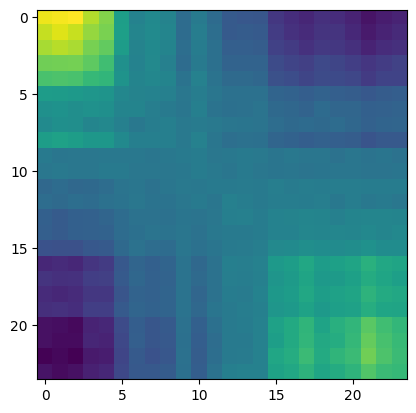

In [136]:
w = model.transformer_blocks[0].attn1.attention_probs
# average over the 8 attention heads
w = w.mean(0)
# w=w[]
# print heatmap
import matplotlib.pyplot as plt

plt.imshow(w.detach().cpu().numpy())
plt.show()


In [126]:
print("Src:", [d["src"] for d in data_piece])
print("Tgt:", [d["tgt"] for d in data_piece])
print("Sample:", each_sample_list)

Src: ['37 63 89 28 43 57 10 33', '34', '44 31', '67 99 56', '517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322 67 402']
Tgt: ['37 63 89 28 43 57 10 33', '34', '44 31', '67 99 56', '517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322 67 402']
Sample: ['37 63 89 28 43 57 10 33', '34', '44 31', '67 99 56', '517 183 293 17 604 595 422 411 426 659 247 279 339 978 324 44 322']


In [137]:

for tgt, gen in zip([d["tgt"].split(" ") for d in data_piece], each_sample_list):
    print(f"----------")
    i = 0
    for t, g in zip(tgt, gen.split(" ")):
        print(f"{i}: {t} -> {g}")
        i += 1

----------
0: 517 -> 517
1: 183 -> 183
2: 293 -> 293
3: 17 -> 17
4: 604 -> 604
5: 595 -> 595
6: 422 -> 422
7: 411 -> 411
8: 426 -> 426
9: 659 -> 659
10: 247 -> 247
11: 279 -> 279
12: 339 -> 339
13: 978 -> 978
14: 324 -> 324
15: 44 -> 44
16: 322 -> 322
----------
0: 67 -> 67
1: 99 -> 99
2: 56 -> 56
